In [2]:
#!pip install gsw -q

# Dask start

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42615")

# Import

In [4]:
import sys
sys.path.insert(1, '..')

In [5]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
import pandas as pd
import cartopy.crs as ccrs
import xgcm
import xesmf as xe
from random import randrange
import os

# Plotting params

In [6]:
#%matplotlib widget
%matplotlib inline

In [7]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [8]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

## Histograms routines

In [9]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [10]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index])
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index])
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

# Load data

Choose cases

In [11]:
data=[dict() for i in range(6)]

In [12]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

In [13]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [14]:
data_slice = dict(t=slice(0,-1,1)) 

In [15]:
chunk_dict = {'x_c' : -1, 'y_c' : -1, 'x_r' : -1, 'y_r' : -1, 't' : 22, 'z_c' : 54, 'z_l' : 54}

In [16]:
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET'] 

In [17]:
%%time
for i in range(len(data)) :
    current_set = xr.open_dataset(f'{SCRATCH_BUCKET}/data'+str(i)+'.zarr', engine="zarr", storage_options={"anon": True}, chunks='auto')
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk(chunk_dict)
    data[i]['LR'] = current_set.persist()

CPU times: user 2.65 s, sys: 446 ms, total: 3.1 s
Wall time: 6.84 s


In [18]:
data[-1]['LR']

<xarray.Dataset>
Dimensions:          (y_c: 47, x_c: 40, t: 90, z_c: 107, x_r: 40, y_r: 47,
                      z_l: 107)
Coordinates: (12/30)
    area             (y_c, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e1f              (y_r, x_r) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e1t              (y_c, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e1u              (y_c, x_r) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e1v              (y_r, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e2f              (y_r, x_r) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    ...               ...
  * x_c              (x_c) int64 1 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40
  * x_r              (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 37.5 38.5 39.5 40.5
  * y_c              (y_c) int64 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47
  * y_r              (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 44.5 45.5 46.5 47.5
  * z_c              (z_c) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * z_l              (z_l) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
Data variables: (12/36)
    dX_p             (t, z_c, y_c, x_c) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    dX_p_error       (t, z_c, y_c, x_c) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    dX_rho_delta     (t, z_c, y_c, x_r) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    dX_rho_model     (t, z_c, y_c, x_r) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    dX_sigma0_delta  (t, z_c, y_c, x_r) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    dX_sigma0_model  (t, z_c, y_c, x_r) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    ...               ...
    vosaline         (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    vosaline_sqr     (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    vosaline_var     (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    votemper         (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    votemper_sqr     (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    votemper_var     (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>

In [19]:
print(data[0]['LR'].nbytes / 1e6, "MiB")

4988.735916 MiB


# Calculate some additional variables

In [20]:
metrics_LR = {
    ('X',): ['e1t', 'e1u', 'e1v'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
    ('Z',): ['e3t', 'e3w'], # Z distances
    ('X', 'Y',): ['area'] }

In [21]:
for i in range(len(data)) :
    data[i]['LR_grid'] = xgcm.Grid(data[i]['LR'], metrics=metrics_LR, periodic=False, \
                         coords={'X' : {'center' : 'x_c', 'right' : 'x_r'}, \
                                'Y' : {'center' : 'y_c', 'right' : 'y_r'},
                                'Z' : {'center' : 'z_c', 'left' : 'z_l'}})
    ds = data[i]['LR']
    grid = data[i]['LR_grid']
    ds['grad_p'] = np.sqrt(ds['dX_p']**2 + ds['dY_p']**2)
    ds['grad_p_error'] = np.sqrt(ds['dX_p_error']**2 + ds['dY_p_error']**2)
    ds['grad_p_error_alignment'] = ((ds['dX_p']*ds['dX_p_error'] + ds['dY_p']*ds['dY_p_error'])/(ds['grad_p']*ds['grad_p_error']))
    ds['relative_grad_p_error'] = (ds['grad_p_error']/ds['grad_p'])

    ds['grad_votemper'] = np.sqrt(grid.interp(ds['dX_votemper']**2, axis='X') + grid.interp(ds['dY_votemper']**2, axis='Y'))
    ds['grad_votemper_var'] = np.sqrt(grid.interp(ds['dX_votemper_var']**2, axis='X') + grid.interp(ds['dY_votemper_var']**2, axis='Y'))
    ds = ds.chunk(chunk_dict)

# Random profiles

Pick 20 random points in (t,x,y) tto make random vertical profiles

In [22]:
random_profiles = [dict({'t': randrange(len(data[-1]['LR'].t)-5), \
                         'x_c': randrange(len(data[-1]['LR'].x_c)-2), \
                         'y_c': randrange(len(data[-1]['LR'].y_c)-2)}) for i in range(20)]
for profile in random_profiles:
    profile['x_r'] = profile['x_c']
    profile['y_r'] = profile['y_c']

# Vertical profiles of variables

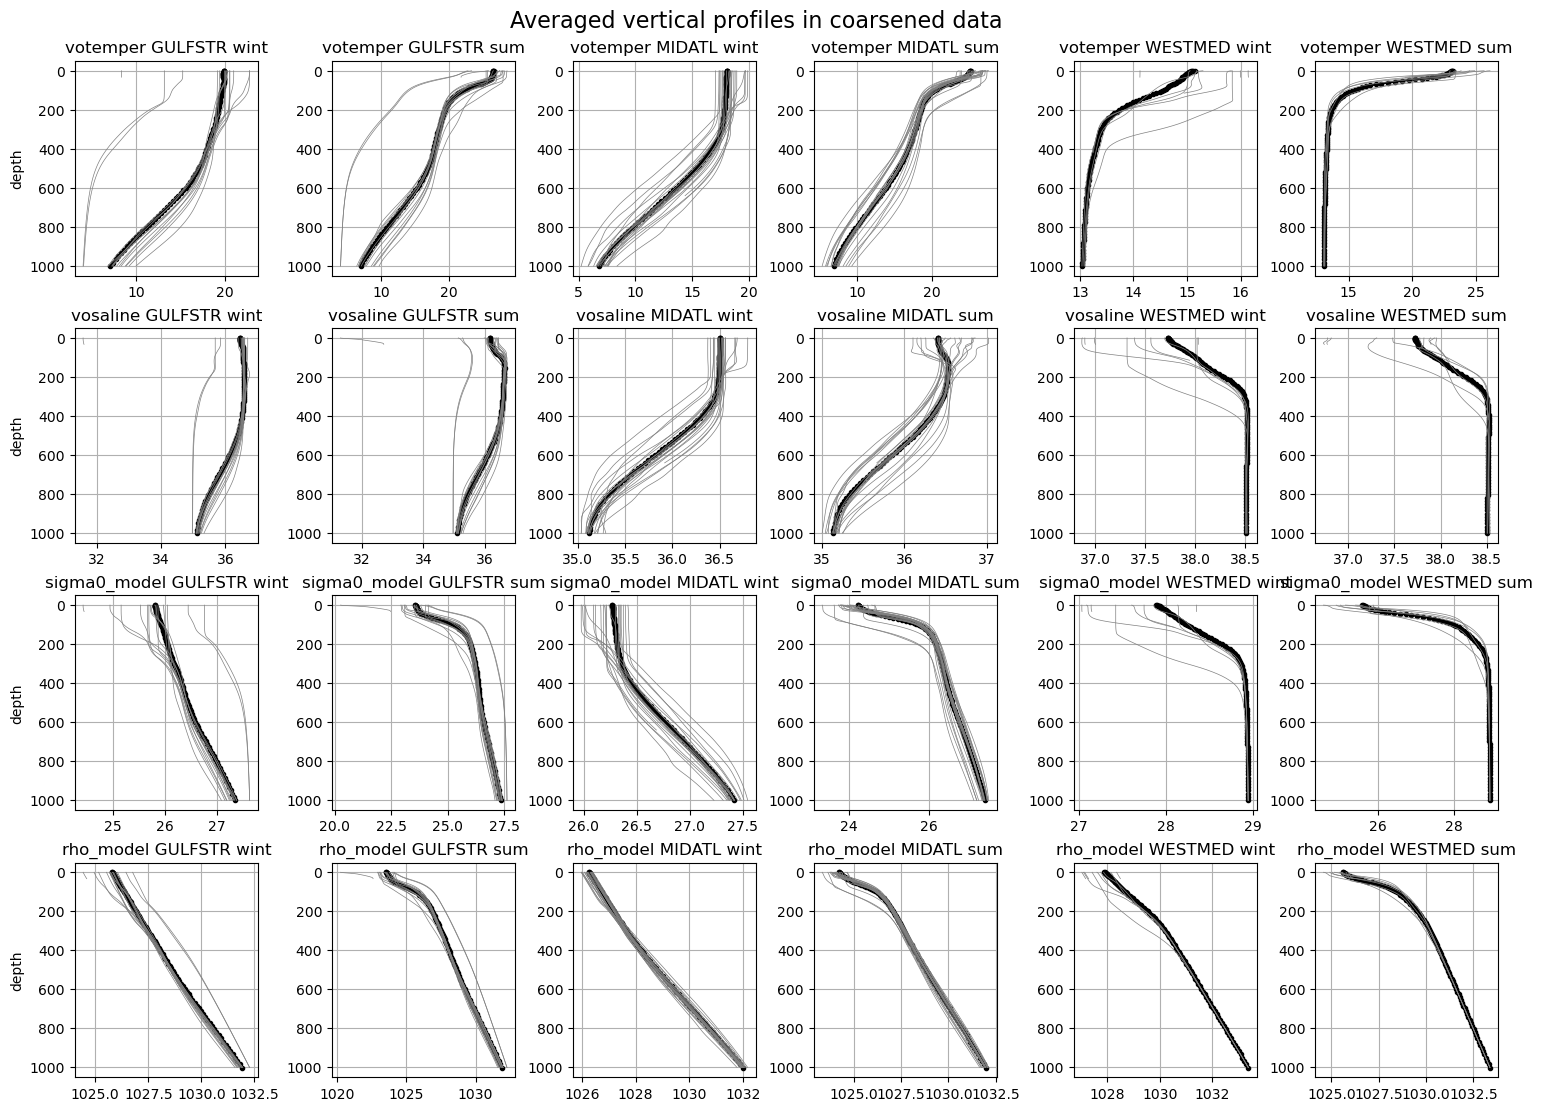

CPU times: user 18.6 s, sys: 1.11 s, total: 19.7 s
Wall time: 1min 59s


In [23]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=4, figsize=(15,11), constrained_layout=True)
fig.suptitle('Averaged vertical profiles in coarsened data', fontsize=16)
for row, variable in enumerate(['votemper', 'vosaline', 'sigma0_model', 'rho_model']) :
    for col in range(len(data)) :
        data[col]['LR'][variable].median(['x_c', 'y_c', 't']).plot(ax=ax[row,col], y='z_c', label=data[col]['label'], marker='.', color='k')
        for profile in random_profiles:
            data[col]['LR'][variable].isel(profile, missing_dims='ignore').plot(ax=ax[row,col], y='z_c', color='grey', ls='-', lw=0.5)
        ax[row,col].set(title=variable+' '+data[col]['label'], xlabel='', ylabel='', xscale='linear', yscale='linear')
        ax[row,col].grid(True)
        ax[row,col].invert_yaxis()
    ax[row,0].set(ylabel='depth')
#ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

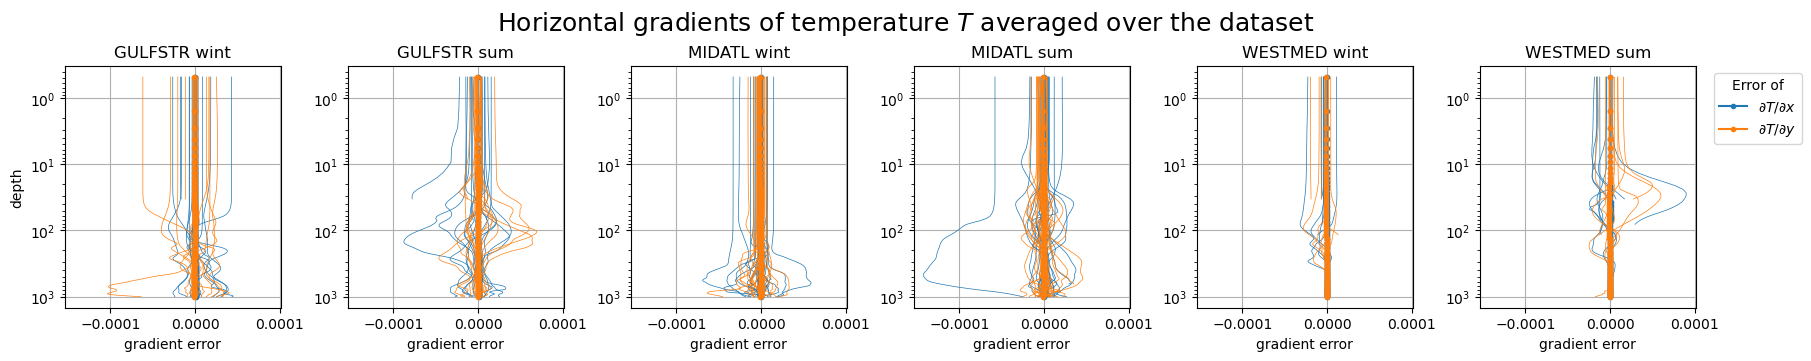

CPU times: user 8.93 s, sys: 430 ms, total: 9.36 s
Wall time: 18 s


In [24]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=True)
fig.suptitle(r'Horizontal gradients of temperature $T$ averaged over the dataset', fontsize=18)
for col in range(len(data)) :
    data[col]['LR']['dX_votemper'].median(['x_r', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[0], label=r'$\partial T/\partial x$', marker='.')
    for profile in random_profiles:
        data[col]['LR']['dX_votemper'].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color=line_colors[0], ls='-', lw=0.5)
    
    data[col]['LR']['dY_votemper'].median(['x_c', 'y_r', 't']).plot(ax=ax[col], y='z_c', color=line_colors[1], label=r'$\partial T/\partial y$', marker='.')
    for profile in random_profiles:
        data[col]['LR']['dY_votemper'].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color=line_colors[1], ls='-', lw=0.5)
        
    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

# Subgrid variance

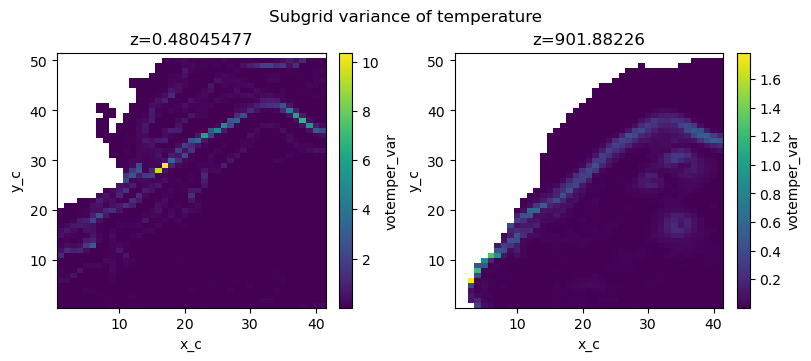

In [25]:
ds = data[0]['LR']

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3.5), constrained_layout=True)
fig.suptitle('Subgrid variance of temperature')
ds.votemper_var.isel(z_c=0, t=0).plot(ax=ax[0])
ds.votemper_var.isel(z_c=100, t=0).plot(ax=ax[1])
ax[0].set(title='z='+str(ds.z_c[0].values))
ax[1].set(title='z='+str(ds.z_c[100].values))
plt.show()

## Vertical profiles

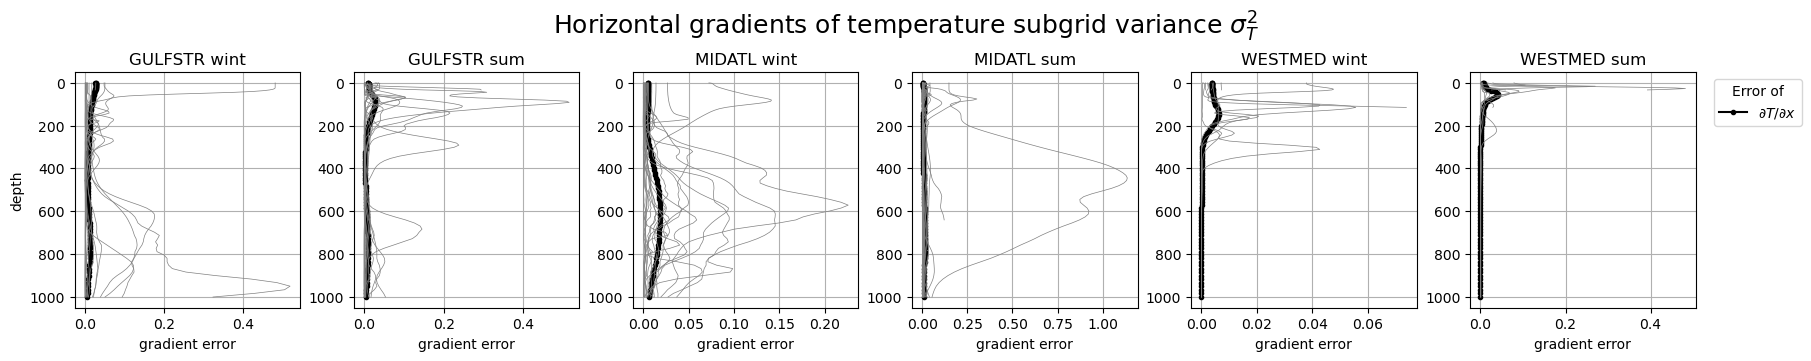

CPU times: user 4.25 s, sys: 191 ms, total: 4.44 s
Wall time: 9.07 s


In [26]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
fig.suptitle(r'Horizontal gradients of temperature subgrid variance $\sigma_T^2$', fontsize=18)
for col in range(len(data)) :
    data[col]['LR']['votemper_var'].median(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', color='k', label=r'$\partial T/\partial x$', marker='.')
    for profile in random_profiles:
        data[col]['LR']['votemper_var'].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color='grey', ls='-', lw=0.5)
    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='linear')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

## Horizontal gradients

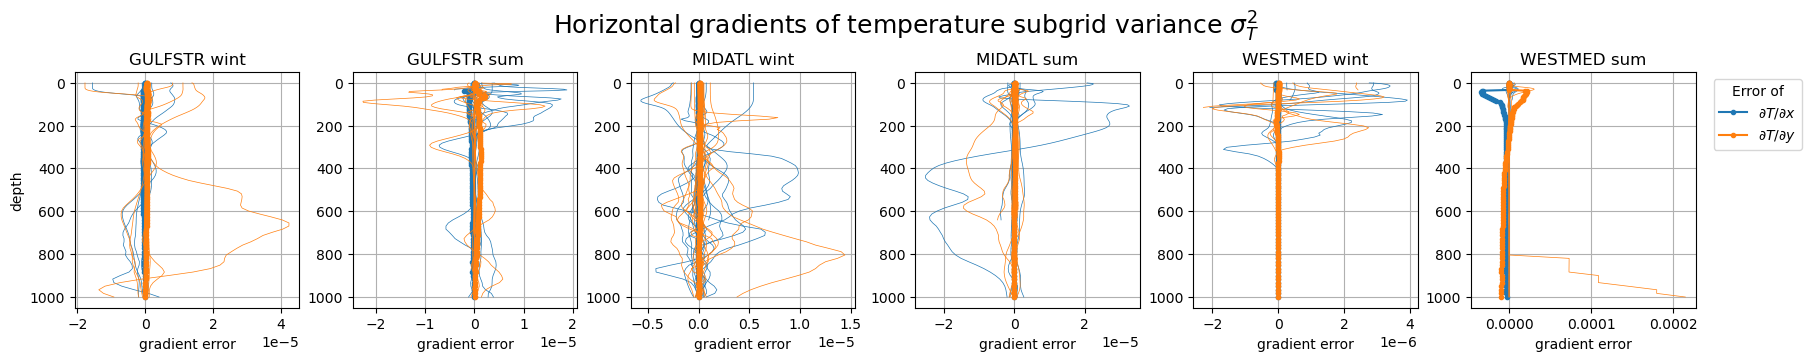

CPU times: user 7.33 s, sys: 318 ms, total: 7.65 s
Wall time: 12.8 s


In [27]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
fig.suptitle(r'Horizontal gradients of temperature subgrid variance $\sigma_T^2$', fontsize=18)
for col in range(len(data)) :
    data[col]['LR']['dX_votemper_var'].mean(['x_r', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[0], label=r'$\partial T/\partial x$', marker='.')
    for profile in random_profiles:
        data[col]['LR']['dX_votemper_var'].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color=line_colors[0], ls='-', lw=0.5)
    
    data[col]['LR']['dY_votemper_var'].mean(['x_c', 'y_r', 't']).plot(ax=ax[col], y='z_c', color=line_colors[1], label=r'$\partial T/\partial y$', marker='.')
    for profile in random_profiles:
        data[col]['LR']['dY_votemper_var'].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color=line_colors[1], ls='-', lw=0.5)
    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='linear')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

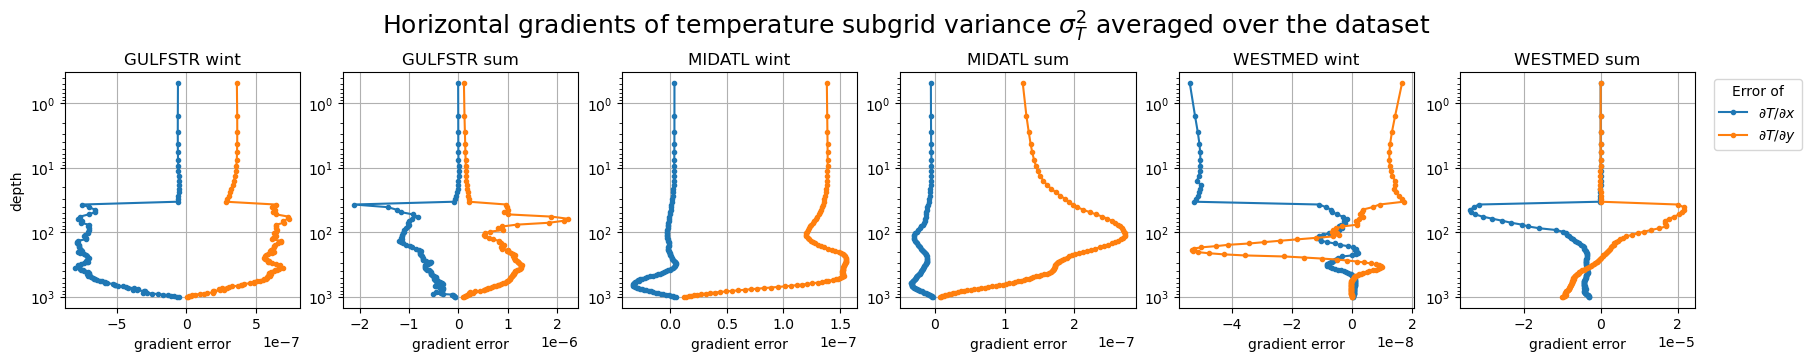

CPU times: user 2.92 s, sys: 50.3 ms, total: 2.97 s
Wall time: 4.06 s


In [28]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
fig.suptitle(r'Horizontal gradients of temperature subgrid variance $\sigma_T^2$ averaged over the dataset', fontsize=18)
for col in range(len(data)) :
    data[col]['LR']['dX_votemper_var'].mean(['x_r', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[0], label=r'$\partial T/\partial x$', marker='.')
    data[col]['LR']['dY_votemper_var'].mean(['x_c', 'y_r', 't']).plot(ax=ax[col], y='z_c', color=line_colors[1], label=r'$\partial T/\partial y$', marker='.')
    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

# Density error

CPU times: user 127 ms, sys: 9.27 ms, total: 136 ms
Wall time: 152 ms


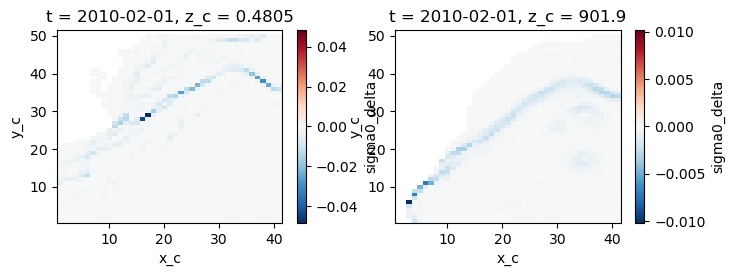

In [29]:
%%time
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,2.5))
data[0]['LR'].sigma0_delta.isel(z_c=0, t=0).plot(ax=ax[0])
data[0]['LR'].sigma0_delta.isel(z_c=100, t=0).plot(ax=ax[1])

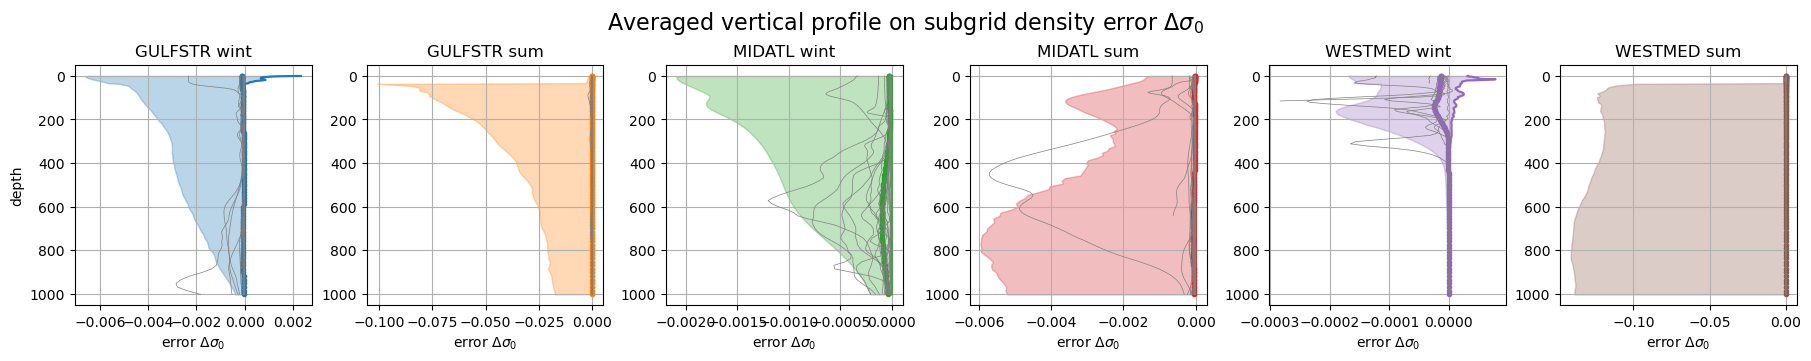

In [30]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
fig.suptitle(r'Averaged vertical profile on subgrid density error $\Delta \sigma_0$', fontsize=16)
variable = 'sigma0_delta'
for index in range(len(data)) :
    median_error = data[index]['LR'][variable].median(['x_c', 'y_c', 't'])
    mean_error = data[index]['LR'][variable].mean(['x_c', 'y_c', 't'])
    error_std = data[index]['LR'][variable].std(['x_c', 'y_c', 't'])
    max_error = data[index]['LR'][variable].max(['x_c', 'y_c', 't'])
    min_error = data[index]['LR'][variable].min(['x_c', 'y_c', 't'])
    
    median_error.plot(ax=ax[index], y='z_c', marker='.', color=line_colors[index])
    max_error.plot(ax=ax[index], y='z_c', marker=None, color=line_colors[index])
    #min_error.plot(ax=ax[index], y='z_c', marker=None, color=line_colors[index])
    for profile in random_profiles:
        data[index]['LR'][variable].isel(profile, missing_dims='ignore').plot(ax=ax[index], y='z_c', color='grey', ls='-', lw=0.5)
    y = data[index]['LR']['z_c']
    x_l = mean_error - error_std
    x_r = xr.where(max_error>(mean_error + error_std), mean_error + error_std, max_error)
    ax[index].fill_betweenx(y, x_l, x_r, alpha=0.3, edgecolor=line_colors[index], facecolor=line_colors[index])
    ax[index].set(title=data[index]['label'], xlabel=r'error $\Delta \sigma_0$', ylabel='', xscale='linear', yscale='linear')
    ax[index].grid(True)
    ax[index].invert_yaxis()
ax[0].set(ylabel='depth')
#ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

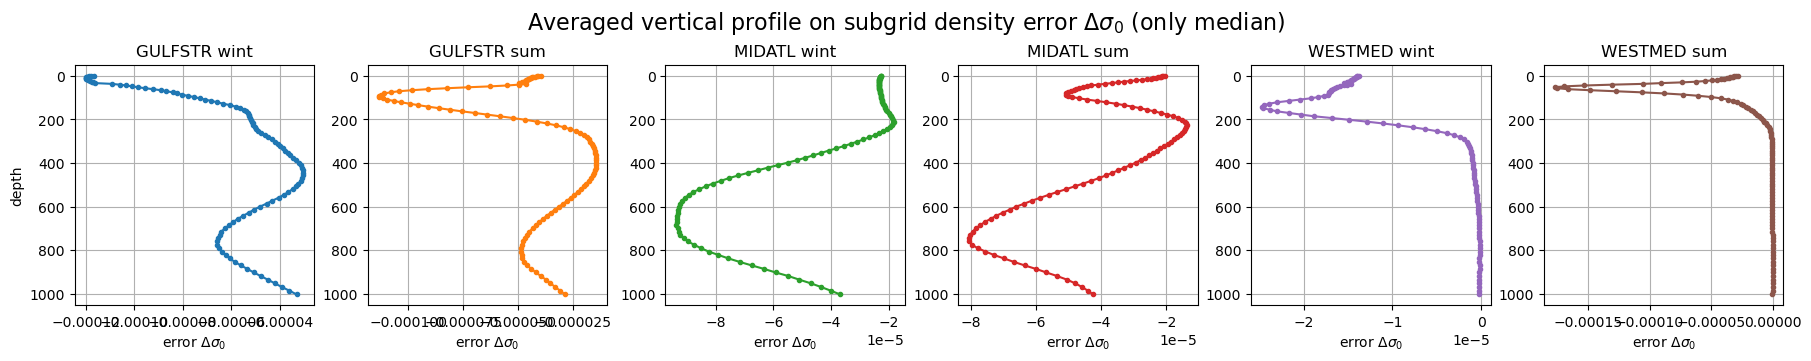

In [31]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
fig.suptitle(r'Averaged vertical profile on subgrid density error $\Delta \sigma_0$ (only median)', fontsize=16)
variable = 'sigma0_delta'
for index in range(len(data)) :
    data[index]['LR'][variable].median(['x_c', 'y_c', 't']).plot(ax=ax[index], y='z_c', marker='.', color=line_colors[index])
    ax[index].set(title=data[index]['label'], xlabel=r'error $\Delta \sigma_0$', ylabel='', xscale='linear', yscale='linear')
    ax[index].grid(True)
    ax[index].invert_yaxis()
ax[0].set(ylabel='depth')
#ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Stratification profile (vertical derivative of density)

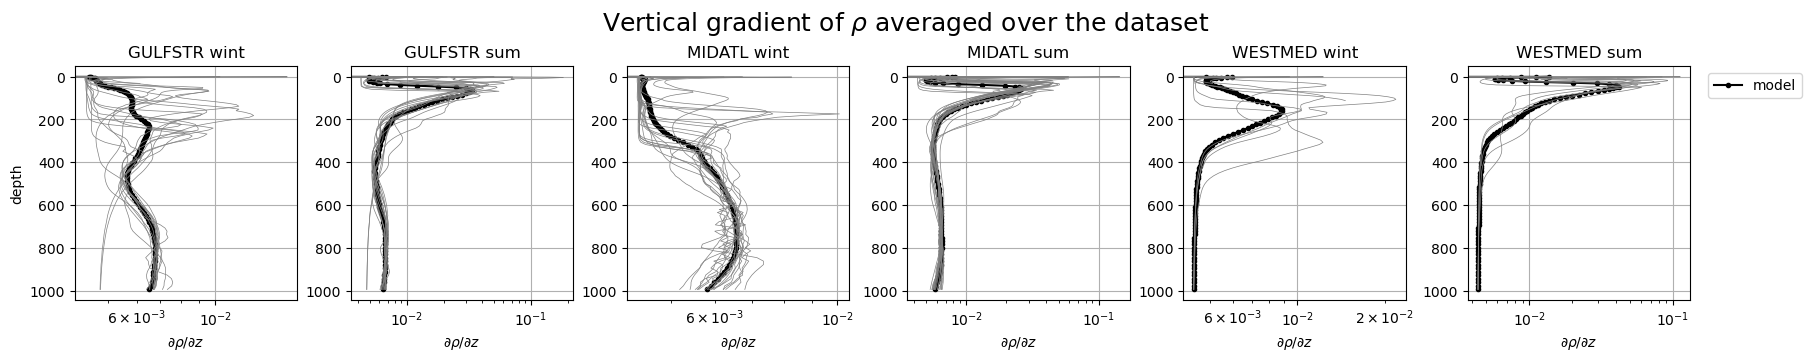

CPU times: user 5.07 s, sys: 186 ms, total: 5.26 s
Wall time: 9.11 s


In [32]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
fig.suptitle(r'Vertical gradient of $\rho$ averaged over the dataset', fontsize=18)
for col in range(len(data)) :
    (data[col]['LR']['dZ_rho_model'].median(['x_c', 'y_c', 't'])).plot(ax=ax[col], y='z_l', label='model',marker='.', color='k')
    for profile in random_profiles:
        data[col]['LR']['dZ_rho_model'].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_l', color='grey', ls='-', lw=0.5)
    ax[col].set(title=data[col]['label'], xlabel=r'$\partial \rho/\partial z$', ylabel='', xscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Horizontal gradients

## Density error horizontal gradient

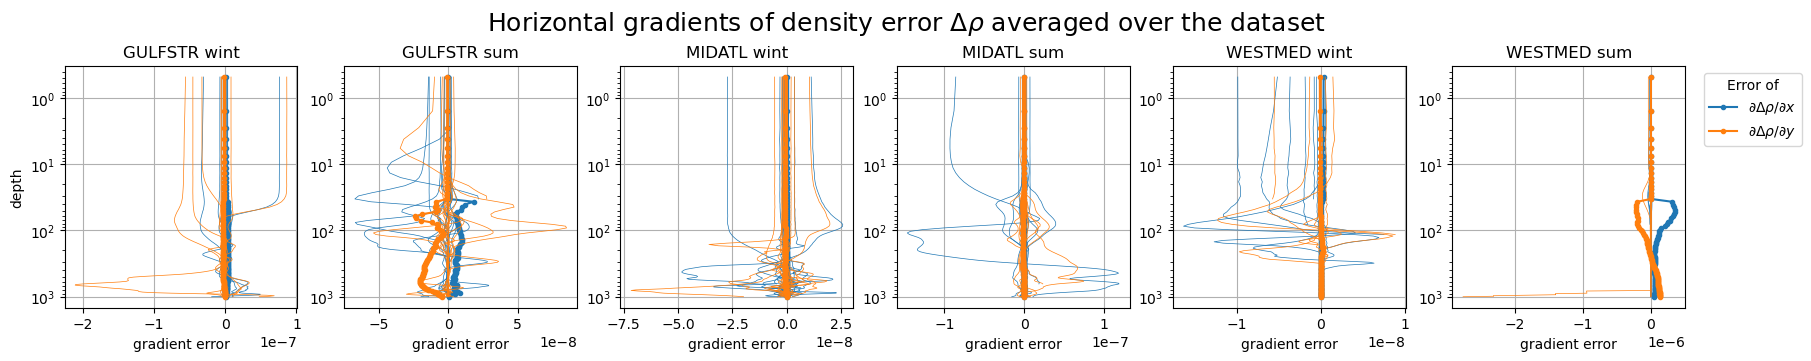

CPU times: user 9.01 s, sys: 341 ms, total: 9.35 s
Wall time: 15 s


In [33]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
fig.suptitle(r'Horizontal gradients of density error $\Delta \rho$ averaged over the dataset', fontsize=18)
variable = 'rho_delta'
for col in range(len(data)) :
    #(data[col]['LR']['dX_p_true']-data[col]['LR']['dX_p_model']).mean(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', label=r'$\partial p/\partial x$', marker='.', color=line_colors[0])
    data[col]['LR']['dX_'+variable].mean(['x_r', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[0], \
                                                                   label=r'$\partial \Delta \rho/\partial x$', marker='.')
    for profile in random_profiles:
        data[col]['LR']['dX_'+variable].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color=line_colors[0], ls='-', lw=0.5)    
    #(data[col]['LR']['dY_p_true']-data[col]['LR']['dY_p_model']).mean(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', label=r'$\partial p/\partial y$', marker='.', color=line_colors[1])
    data[col]['LR']['dY_'+variable].mean(['x_c', 'y_r', 't']).plot(ax=ax[col], y='z_c', color=line_colors[1], \
                                                                   label=r'$\partial \Delta \rho/\partial y$', marker='.', )
    for profile in random_profiles:
        data[col]['LR']['dY_'+variable].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color=line_colors[1], ls='-', lw=0.5)    

    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

# Pressure gradient

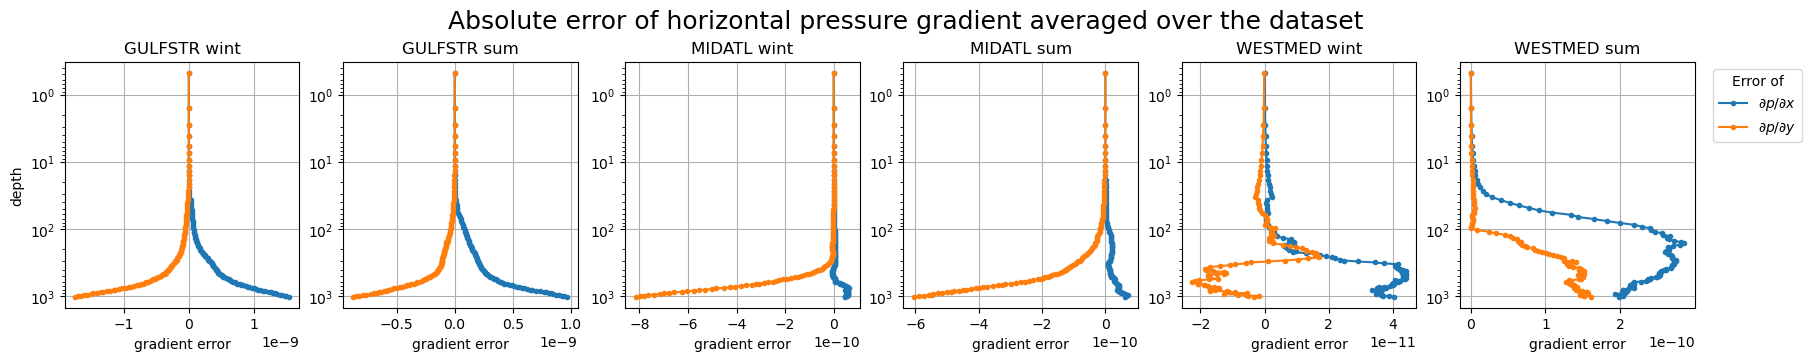

CPU times: user 2.6 s, sys: 55.2 ms, total: 2.65 s
Wall time: 6.52 s


In [34]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
variable = 'p_error'
fig.suptitle(r'Absolute error of horizontal pressure gradient averaged over the dataset', fontsize=18)
for col in range(len(data)) :
    data[col]['LR']['dX_'+variable].median(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[0], \
                                                                 label=r'$\partial p/\partial x$', marker='.') 
    data[col]['LR']['dY_'+variable].median(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[1], \
                                                                 label=r'$\partial p/\partial y$', marker='.', )
    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

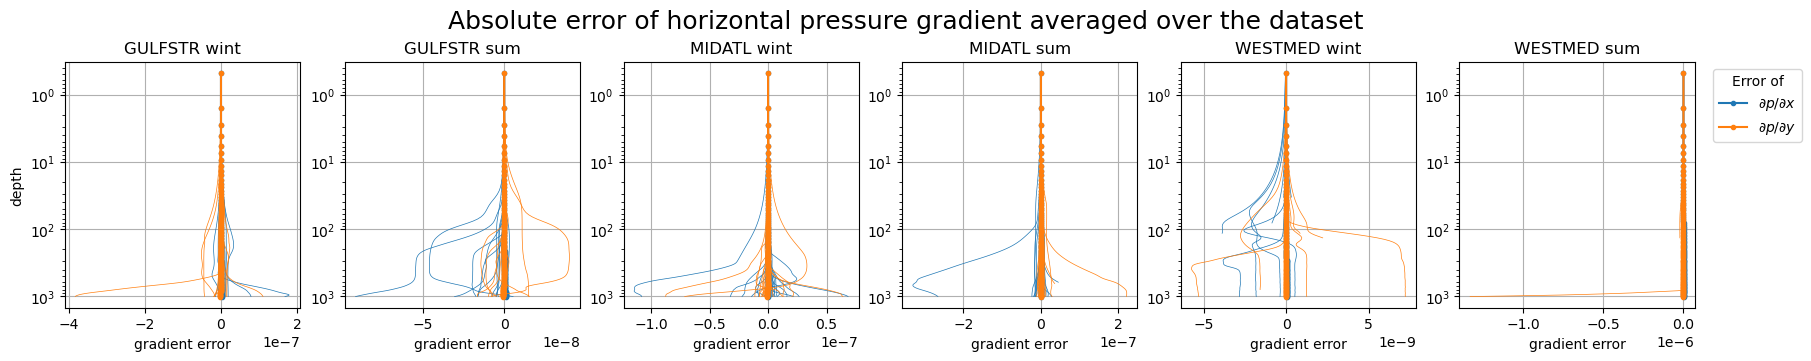

CPU times: user 9.4 s, sys: 328 ms, total: 9.72 s
Wall time: 17.5 s


In [35]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
variable = 'p_error'
fig.suptitle(r'Absolute error of horizontal pressure gradient averaged over the dataset', fontsize=18)
for col in range(len(data)) :
    data[col]['LR']['dX_'+variable].median(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[0], \
                                                                 label=r'$\partial p/\partial x$', marker='.')
    for profile in random_profiles:
        data[col]['LR']['dX_'+variable].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color=line_colors[0], ls='-', lw=0.5)    

    data[col]['LR']['dY_'+variable].median(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[1], \
                                                                 label=r'$\partial p/\partial y$', marker='.', )
    for profile in random_profiles:
        data[col]['LR']['dY_'+variable].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color=line_colors[1], ls='-', lw=0.5)    

    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

## Relative pressure error

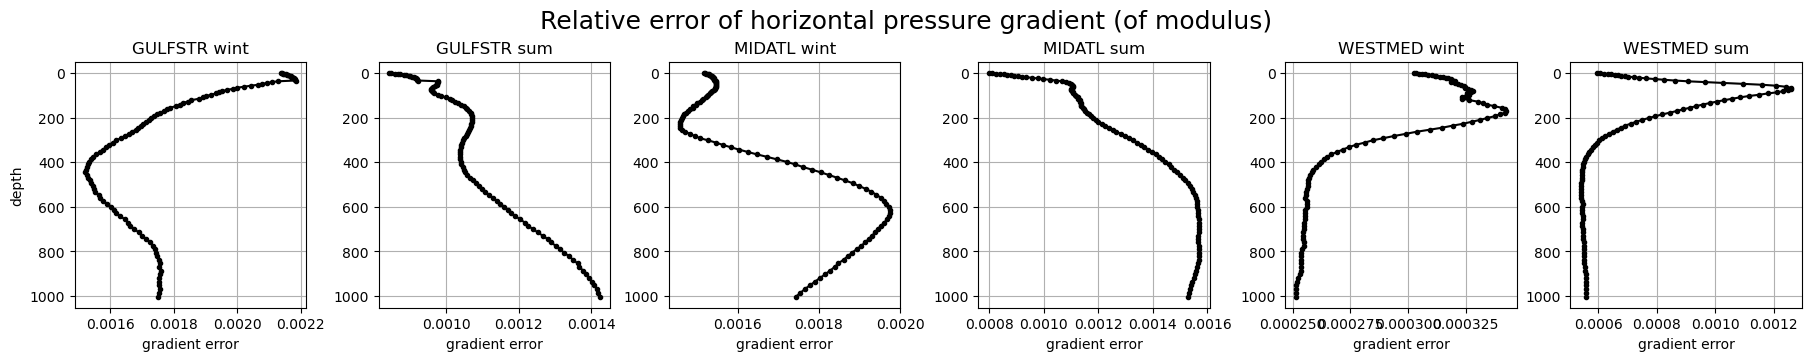

CPU times: user 1.15 s, sys: 32.3 ms, total: 1.18 s
Wall time: 8.18 s


In [36]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
variable = 'relative_grad_p_error'
fig.suptitle(r'Relative error of horizontal pressure gradient (of modulus)', fontsize=18)
for col in range(len(data)) :
    data[col]['LR'][variable].median(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', color='k', marker='.')
    #for profile in random_profiles:
    #    data[col]['LR'][variable].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color='grey', ls='-', lw=0.5)    

    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='linear')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
#ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

## Alignment

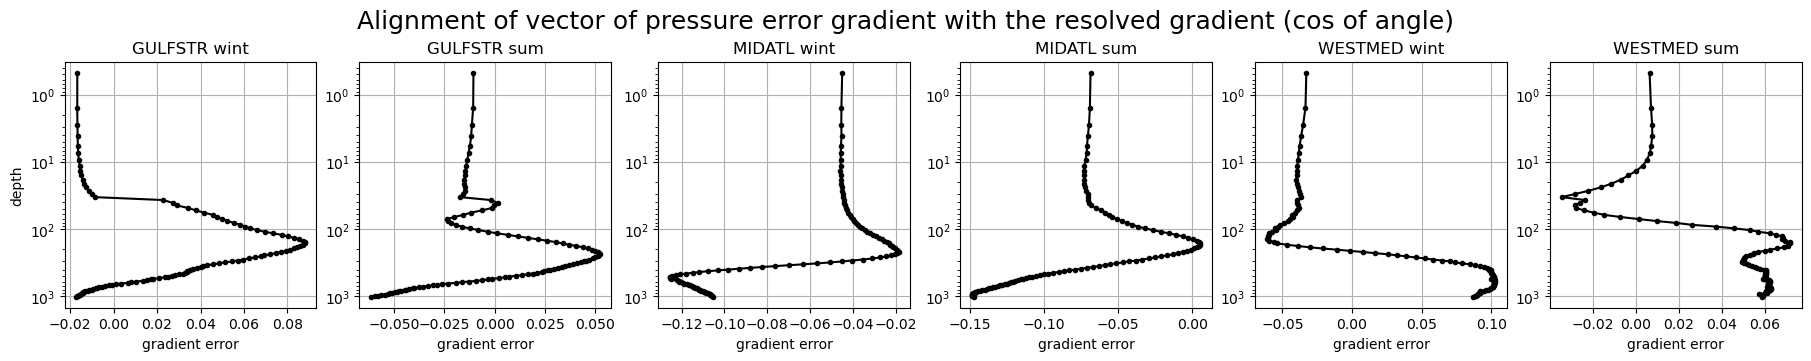

CPU times: user 2.51 s, sys: 35.1 ms, total: 2.55 s
Wall time: 5.98 s


In [37]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
variable = 'grad_p_error_alignment'
fig.suptitle(r'Alignment of vector of pressure error gradient with the resolved gradient (cos of angle)', fontsize=18)
for col in range(len(data)) :
    data[col]['LR'][variable].mean(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', color='k', marker='.')
    #for profile in random_profiles:
    #    data[col]['LR'][variable].isel(profile, missing_dims='ignore').plot(ax=ax[col], y='z_c', color='grey', ls='-', lw=0.5)    

    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
#ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

# Compare profiles

For temperature

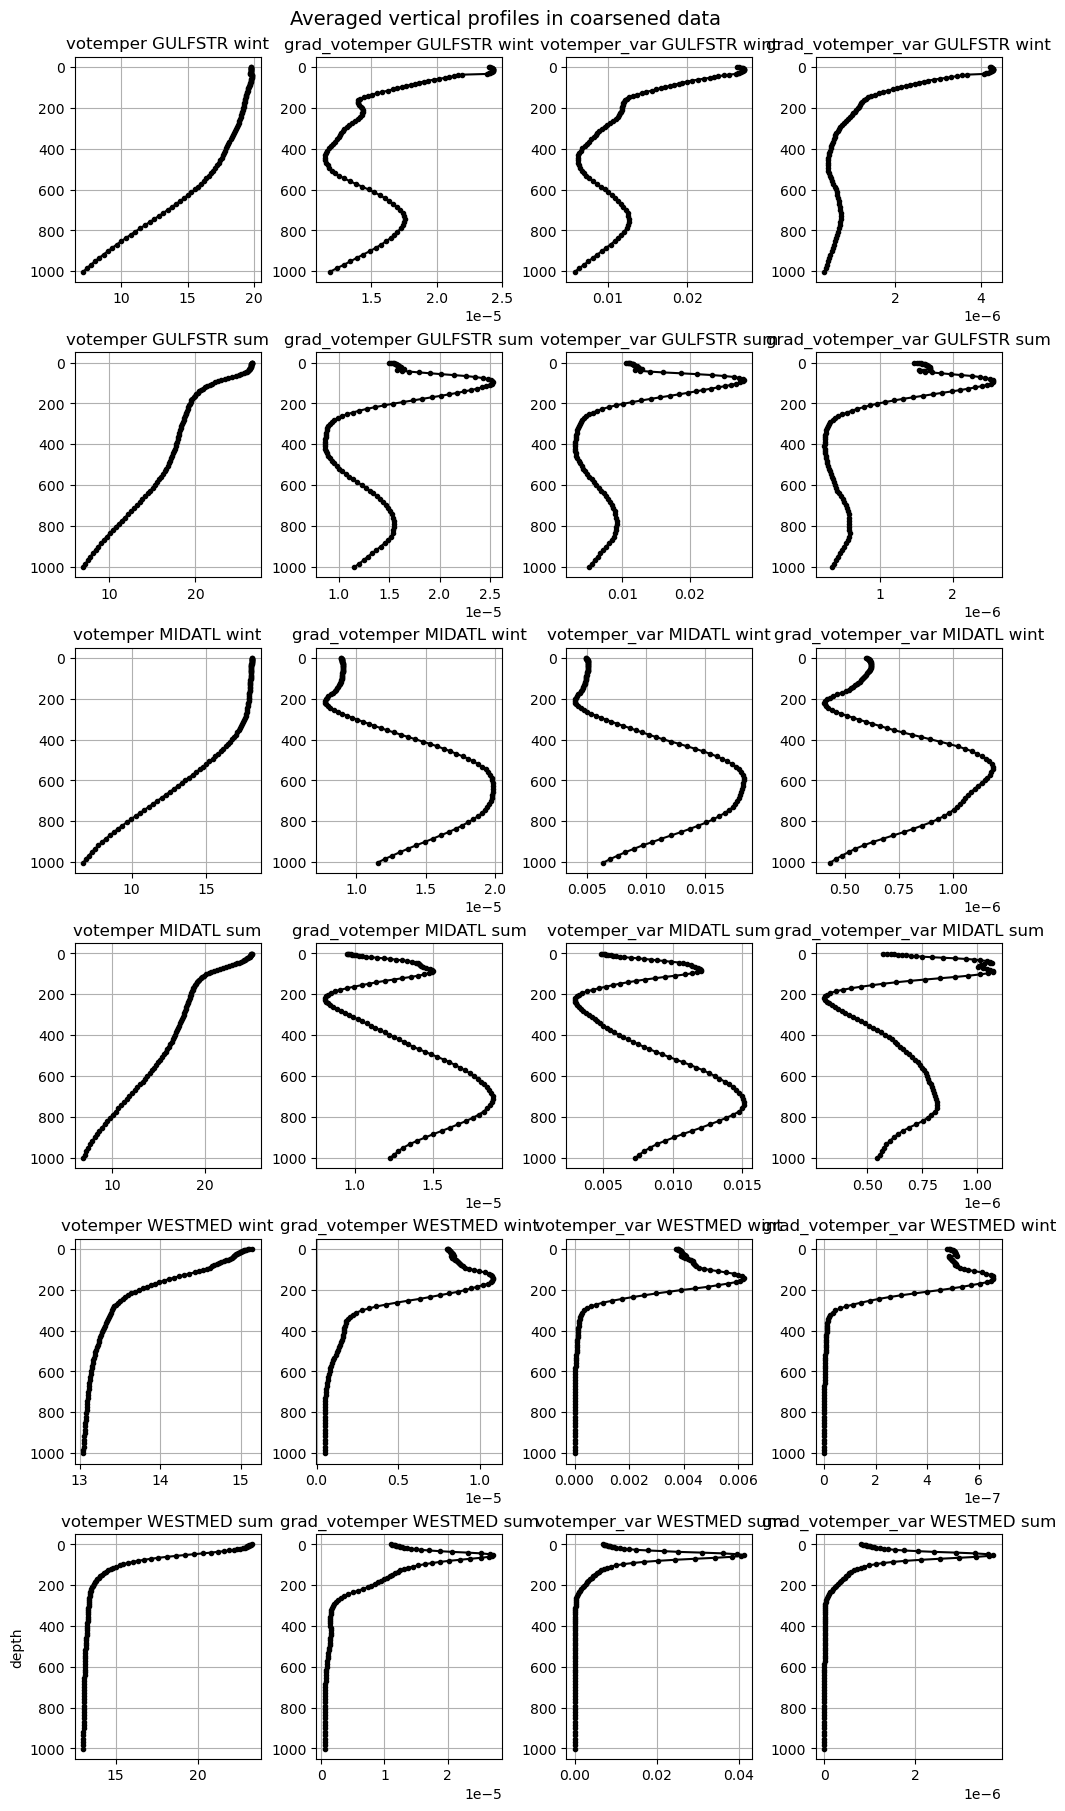

CPU times: user 4.07 s, sys: 115 ms, total: 4.19 s
Wall time: 20 s


In [41]:
%%time
variables = ['votemper', 'grad_votemper', 'votemper_var', 'grad_votemper_var']

fig, ax = plt.subplots(ncols=len(variables), nrows=len(data), figsize=(10,18), constrained_layout=True, squeeze=False)
fig.suptitle('Averaged vertical profiles in coarsened data', fontsize=14)
for col, variable in enumerate(variables) :
    for row, data_entity in enumerate(data) :
        data_entity['LR'][variable].median(['x_c', 'y_c', 't']).plot(ax=ax[row,col], y='z_c', label=data_entity['label'], marker='.', color='k')
        #for profile in random_profiles:
        #    data_entity['LR'][variable].isel(profile, missing_dims='ignore').plot(ax=ax[row,col], y='z_c', color='grey', ls='-', lw=0.5)
        ax[row,col].set(title=variable+' '+data_entity['label'], xlabel='', ylabel='', xscale='linear', yscale='linear')
        ax[row,col].grid(True)
        ax[row,col].invert_yaxis()
    ax[row,0].set(ylabel='depth')
#ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()